In [18]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_pytorch import FR_algorithm

import torch
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm
import random
seed=50
random.seed(seed)

goal='sync'
bifurcation='high'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 10 nodes
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
#A = np.zeros((5,5))
parameters['A'] = A
parameters['N'] = n_nodes


#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

def set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise):

    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']

    #set random initials on circle with set amplitudes
    if bifurcation=='low':
        ini_y=torch.rand(N)/2+0.1
        ini_z=torch.rand(N)/5+.5
    elif bifurcation=='high':
        ini_y=torch.rand(N)
        ini_z=torch.rand(N)*0.3+1.0
    
    ini_transient=torch.stack((ini_y, ini_z)).transpose(0, 1)
    ini_transient=ini_transient.reshape(2,N)
    #print(ini_transient)

    return ini_transient

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
#ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)
target_output=torch.ones((parameters['N'],parameters['N']))

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

In [19]:
def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=torch.min(data)
    maxx=torch.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(torch.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

In [43]:
def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=torch.min(data)
    maxx=torch.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(torch.arange(0,int(dt*data.shape[0]),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

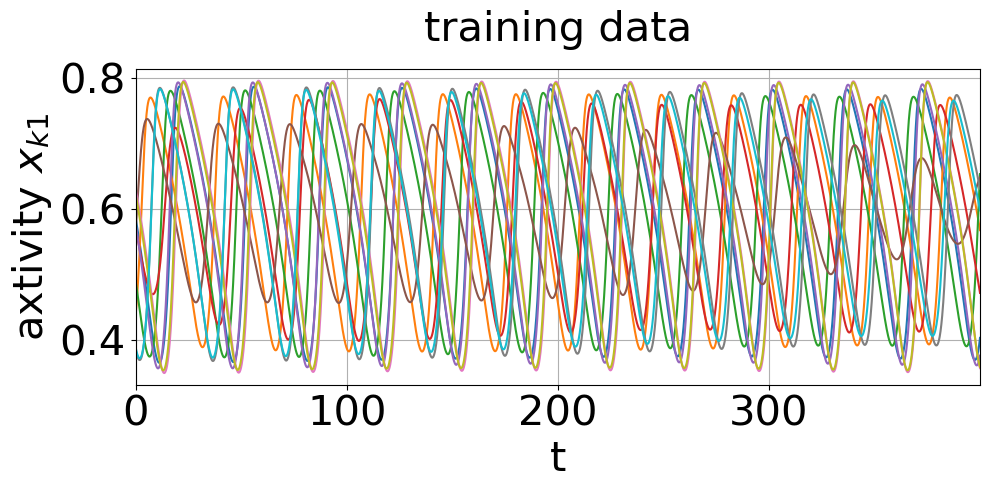

In [21]:
nocontrol=torch.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)
create_plot(state_uncontrolled[:,0,:],'axtivity $x_{k1}$','training data')
plt.show()

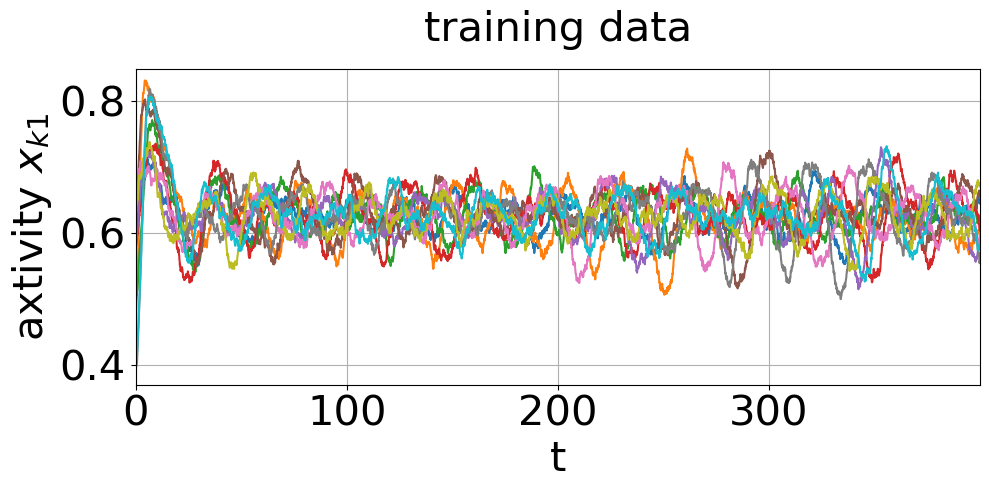

In [22]:
randcontrol=0.1*torch.rand((tsteps,parameters['N']))
state_randcontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,randcontrol, **args)
create_plot(state_randcontrolled[:,0,:],'axtivity $x_{k1}$','training data')
plt.show()

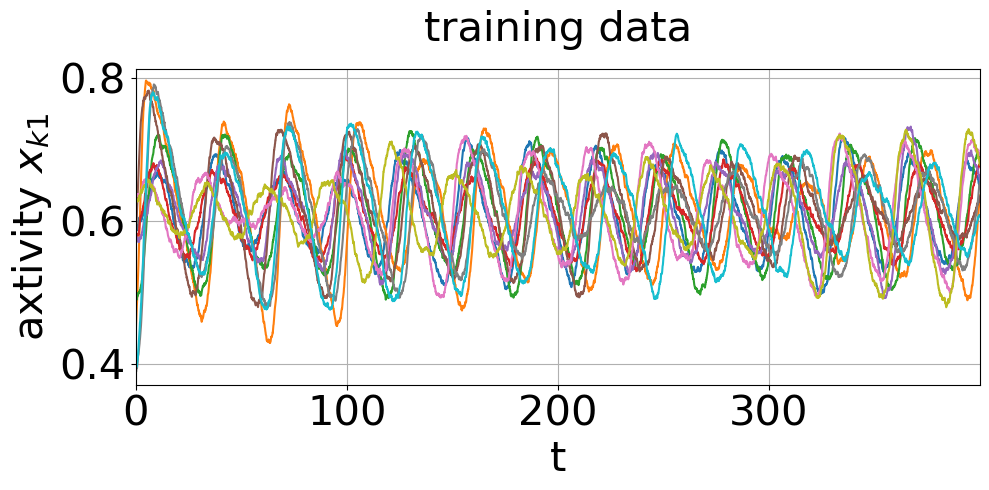

In [23]:
randcontrol2=0.05*torch.rand((tsteps,parameters['N']))
state_randcontrolled2=functions.plot_runge_kutta(functions.ODE_FHN_network,randcontrol2, **args)
create_plot(state_randcontrolled2[:,0,:],'axtivity $x_{k1}$','training data')
plt.show()

In [24]:
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer

In [25]:
trajectories = [(state_uncontrolled[:1000,:,:],nocontrol[:1000,:]),(state_randcontrolled,randcontrol),(state_randcontrolled2,randcontrol2)]
for (tr,c) in trajectories:
    print(tr.shape,c.shape)

torch.Size([1000, 2, 10]) torch.Size([1000, 10])
torch.Size([4000, 2, 10]) torch.Size([4000, 10])
torch.Size([4000, 2, 10]) torch.Size([4000, 10])


In [26]:
traj_states = torch.cat((state_uncontrolled, state_randcontrolled, state_randcontrolled2), dim=0).to(device)
traj_controls = torch.cat((nocontrol, randcontrol, randcontrol2), dim=0).unsqueeze(1).to(device)
state_control = torch.cat((traj_states,traj_controls),dim=1)
print(traj_states.shape,traj_controls.shape,state_control.shape)

torch.Size([12000, 2, 10]) torch.Size([12000, 1, 10]) torch.Size([12000, 3, 10])


In [52]:
from torch.utils.data import DataLoader, TensorDataset, random_split

look_back = 3 # the number of previous time steps to use as input variables to predict the next time period
look_forward = 3 # k steps ahead
data = []

for (trajectory,c) in trajectories:
    for i in range(len(trajectory) - 1):
        state, control, next_state = trajectory[i,:,:], c[i,:], trajectory[i+1,:,:]
        data.append((state, control, next_state))

# Convert data to PyTorch tensors and create a DataLoader for batching
states, controls, next_states = zip(*data)
states_tensor = torch.stack(states)
controls_tensor = torch.stack(controls)
next_states_tensor = torch.stack(next_states)
dataset = TensorDataset(states_tensor, controls_tensor, next_states_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

In [27]:
adj = torch.ones(n_nodes,n_nodes)
torch.diagonal(adj, 0).zero_()
edge_index = adj.nonzero().t().contiguous()
edge_attr = A[edge_index[0], edge_index[1]]

In [86]:
edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
         7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
         3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
         0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [144]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr,u=None,batch=None):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #if edge_attr.dim() == 1:
            #edge_attr = edge_attr.view(-1, 1)
        #print(dst[:,0,:].shape,edge_attr.shape)
        print(dst.shape,edge_attr.shape)
        print(dst,edge_attr)
        dst[:,0] = dst[:,0] * edge_attr
        
        return dst

class NodeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 2*3
        hiddens = 2*in_channels
        self.node_mlp_1 = Sequential(
            nn.Linear(in_channels, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, in_channels))
        num_node_features = 2
        self.node_mlp_2 = Sequential(
            nn.Linear(3*3, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, num_node_features))

    def forward(self, x, edge_index, edge_attr,u=None,batch=None):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        #print(x[row].shape,edge_attr.shape)
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        #print(out.shape)
        out = scatter(out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')
        #print(x.shape,out.shape)
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

In [173]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr,u=None,batch=None):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        
        out = dst[:,0] * edge_attr
        
        return out.unsqueeze(1)

class NodeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 3+1
        hiddens = 2*in_channels
        self.node_mlp_1 = Sequential(
            nn.Linear(in_channels, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, in_channels))
        num_node_features = 2
        self.node_mlp_2 = Sequential(
            nn.Linear(7, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, num_node_features))

    def forward(self, x, edge_index, edge_attr,u=None,batch=None):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter(out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

In [165]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr,u=None,batch=None):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #if edge_attr.dim() == 1:
            #edge_attr = edge_attr.view(-1, 1)
        #print(dst[:,0,:].shape,edge_attr.shape)
        #print(dst.shape,edge_attr.shape)
        dst[:,0] = dst[:,0] * edge_attr
        
        return dst

class NodeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 2*3
        hiddens = 2*in_channels
        self.node_mlp_1 = Sequential(
            nn.Linear(in_channels, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, in_channels))
        num_node_features = 2
        in_channels_2 = 3*3
        hiddens_2 = 2*in_channels_2
        self.node_mlp_2 = Sequential(
            nn.Linear(in_channels_2, hiddens_2),
            nn.ReLU(),
            nn.Linear(hiddens_2, in_channels_2),
            nn.ReLU(),
            nn.Linear(in_channels_2, num_node_features))

    def forward(self, x, edge_index, edge_attr,u=None,batch=None):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        print(x[row].shape,edge_attr.shape)
        out = torch.cat([x[row], edge_attr], dim=1)
        print(out.shape)
        out = self.node_mlp_1(out)
        #print(out.shape)
        out = scatter(out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')
        #print(x.shape,out.shape)
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

In [200]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr, u, batch):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.

        return src[:, 0] * edge_attr

class NodeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        num_node_features = 2
        in_channels = 3+1 
        hiddens = 2*in_channels
        #self.node_mlp = Sequential(
            #nn.Linear(in_channels, hiddens),
            #nn.ReLU(),
            #nn.Linear(hiddens, in_channels),
            #nn.ReLU(),
            #nn.Linear(in_channels, num_node_features))
        self.node_mlp = Sequential(
            nn.Linear(in_channels, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, 2*hiddens),
            nn.ReLU(),
            nn.Linear(2*hiddens, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, num_node_features))
        
    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out = torch.cat([x, out.unsqueeze(1)], dim=1)
        return self.node_mlp(out)

In [201]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
data = state_uncontrolled.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()
look_ahead = 10

train_losses = []  
val_losses = []
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
                                         
    for t in range(1,traj_states.shape[0]-look_ahead+1):
        
        optimizer.zero_grad()
        #make 1 step prediction for the next k steps
        loss = 0
        current_state = torch.cat((traj_states[t-1,:],traj_controls[t-1,:]),dim=0)
        for k in range(look_ahead):
            #print(current_state.shape)
            prediction = model(current_state.T,edge_index,edge_attr)[0].T
            loss = loss + loss_fn(prediction, traj_states[t+k,:])
            #print(prediction.shape,traj_controls[t+k,:].shape)
            current_state = torch.cat((prediction,traj_controls[t+k,:]),dim=0)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_train_loss = total_loss / traj_states.shape[0]
    train_losses.append(avg_train_loss) 
    if (epoch + 1) % 5 == 0: 
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / traj_states.shape[0]}")

Epoch 5/50, Loss: 0.002813521372399312
Epoch 10/50, Loss: 0.0026580683259708167
Epoch 15/50, Loss: 0.0020211530156307163
Epoch 20/50, Loss: 0.00204079603847822
Epoch 25/50, Loss: 0.002027710366181661
Epoch 30/50, Loss: 0.001983965988102379
Epoch 35/50, Loss: 0.0020144454034765054
Epoch 40/50, Loss: 0.0019997560810176463
Epoch 45/50, Loss: 0.0020512845917067656
Epoch 50/50, Loss: 0.002025176568573746


In [215]:
additional_epochs = 50

# Continue training for additional epochs
for epoch in range(additional_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    
    for t in range(1, traj_states.shape[0] - look_ahead + 1):        
        optimizer.zero_grad()
        loss = 0
        current_state = torch.cat((traj_states[t-1,:], traj_controls[t-1,:]), dim=0)       
        for k in range(look_ahead):
            prediction = model(current_state.T, edge_index, edge_attr)[0].T
            loss = loss + loss_fn(prediction, traj_states[t+k,:])
            current_state = torch.cat((prediction, traj_controls[t+k,:]), dim=0)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / traj_states.shape[0]
    train_losses.append(avg_train_loss)  # Keep appending to the same list
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{additional_epochs}, Loss: {avg_train_loss}")


Epoch 5/50, Loss: 0.0020309743592030523
Epoch 10/50, Loss: 0.0020165931566822714
Epoch 15/50, Loss: 0.002017694608039771
Epoch 20/50, Loss: 0.0020107717829426597
Epoch 25/50, Loss: 0.002006166410365343
Epoch 30/50, Loss: 0.002008553385248282
Epoch 35/50, Loss: 0.0020005497547848183
Epoch 40/50, Loss: 0.002001840444315349
Epoch 45/50, Loss: 0.0019955110600167244
Epoch 50/50, Loss: 0.0019911881438529236


In [214]:
torch.save(model.state_dict(), 'f10_edge1_src_mlp6_e150')

In [209]:
torch.save(model.state_dict(), 'f10_edge1_src_mlp6_e100')

In [205]:
torch.save(model.state_dict(), 'f10_edge1_src_mlp6_e50')

In [199]:
torch.save(model.state_dict(), 'f10_edge1_src_mlp3')

In [197]:
train_losses

[0.06307946851169376,
 0.003048669519414034,
 0.0025670883100146966,
 0.0023581793052668823,
 0.002162559551957202,
 0.0018590693636251672,
 0.0005698666366417153,
 0.0002626007222521215,
 0.000301061393854449,
 0.00029628158803526124,
 0.0002978536151909642,
 0.0002945409657908916,
 0.0002956245835104596,
 0.0002931335067824534,
 0.0002928924049481149,
 0.00029157971998118153,
 0.00028989235899218595,
 0.0002115068526082003,
 0.0002923088027085233,
 0.0002889876843439462,
 0.00029017128144139784,
 0.00029137247655362824,
 0.00028844677928121127,
 0.000289321624863419,
 0.00028970105735442076,
 0.00029149785212505703,
 0.00028771826177993867,
 0.00029085768997576147,
 0.00029068681506640815,
 0.00029014464675251856,
 0.0002903305057021536,
 0.0002914372464276198,
 0.0002909937241929678,
 0.0002911466489939964,
 0.0002905049177794202,
 0.0002901215807691339,
 0.0002907203055479878,
 0.0002910454510615068,
 0.0002901476013101008,
 0.00029156399258768793,
 0.0002910789177850953,
 0.000291

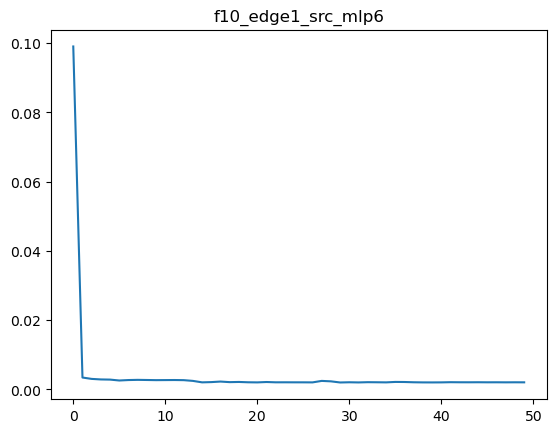

In [202]:
plt.plot(train_losses)
plt.title('f10_edge1_src_mlp6')
plt.show()

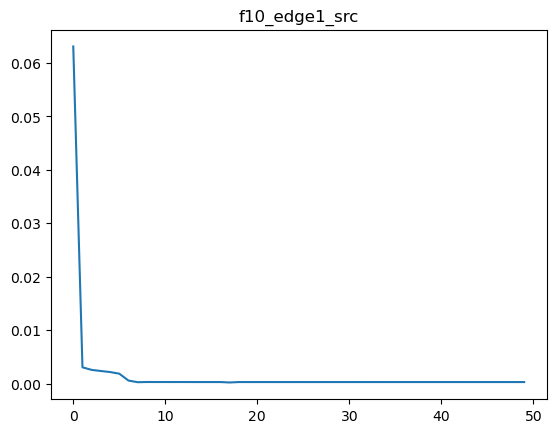

In [194]:
plt.plot(train_losses)
plt.title('f10_edge1_src')
plt.show()

In [218]:
model.eval()
data = state_uncontrolled.to(device)
pred_traj = torch.zeros(500,2,10)
pred_traj[0,:,:] = state_uncontrolled[0,:,:]
nocontrol_test = torch.zeros(n_nodes).unsqueeze(0).to(device) 
for i in range(500-1):
    x = torch.cat((pred_traj[i,:,:], nocontrol_test), dim=0)
    pred = model(x.T,edge_index,edge_attr)[0]
    pred_traj[i+1,:,:] = pred.T

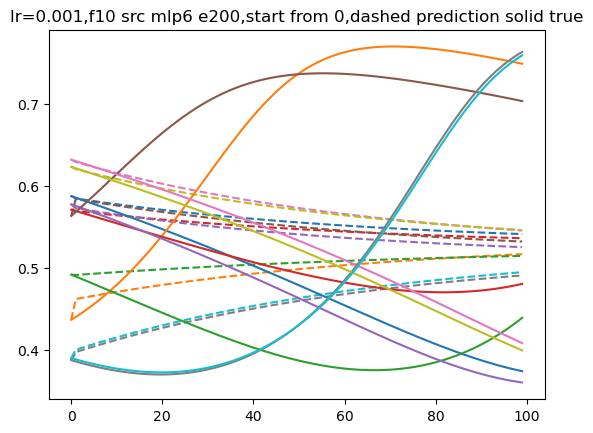

In [219]:
plt.plot(pred_traj[:100,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:100,0,:],label='true')
plt.title('lr=0.001,f10 src mlp6 e200,start from 0,dashed prediction solid true')
plt.show()

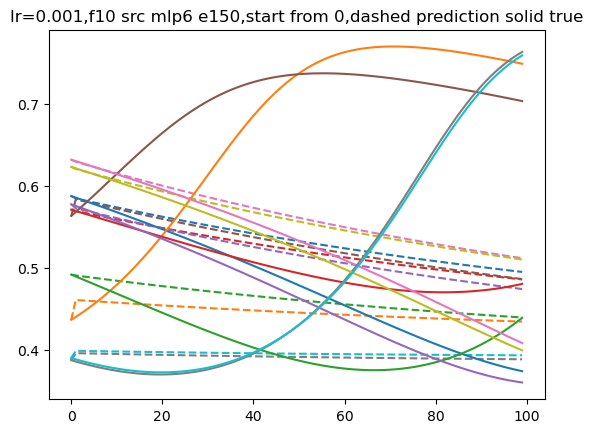

In [213]:
plt.plot(pred_traj[:100,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:100,0,:],label='true')
plt.title('lr=0.001,f10 src mlp6 e150,start from 0,dashed prediction solid true')
plt.show()

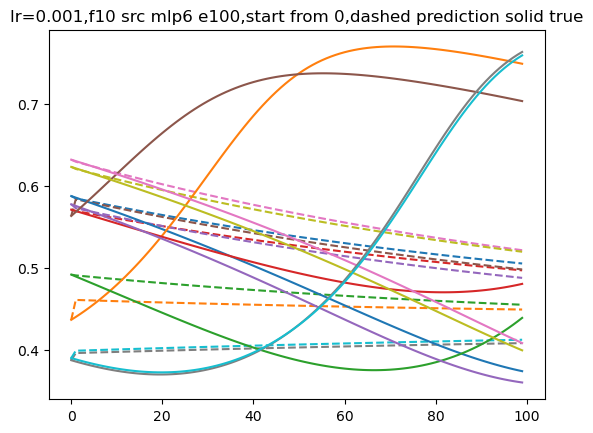

In [208]:
plt.plot(pred_traj[:100,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:100,0,:],label='true')
plt.title('lr=0.001,f10 src mlp6 e100,start from 0,dashed prediction solid true')
plt.show()

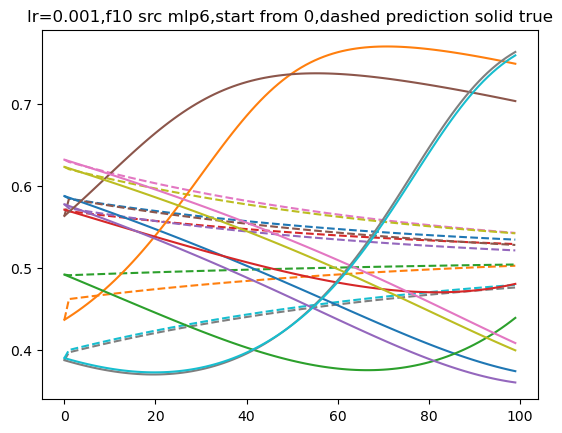

In [204]:
plt.plot(pred_traj[:100,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:100,0,:],label='true')
plt.title('lr=0.001,f10 src mlp6,start from 0,dashed prediction solid true')
plt.show()

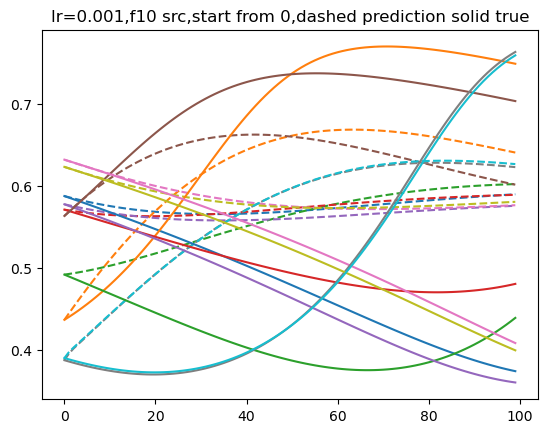

In [196]:
plt.plot(pred_traj[:100,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:100,0,:],label='true')
plt.title('lr=0.001,f10 src,start from 0,dashed prediction solid true')
plt.show()

In [174]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
data = state_uncontrolled.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()
look_ahead = 10

train_losses = []  
val_losses = []
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
                                         
    for t in range(1,traj_states.shape[0]-look_ahead+1):
        
        optimizer.zero_grad()
        #make 1 step prediction for the next k steps
        loss = 0
        current_state = torch.cat((traj_states[t-1,:],traj_controls[t-1,:]),dim=0)
        for k in range(look_ahead):
            #print(current_state.shape)
            prediction = model(current_state.T,edge_index,edge_attr)[0].T
            loss = loss + loss_fn(prediction, traj_states[t+k,:])
            #print(prediction.shape,traj_controls[t+k,:].shape)
            current_state = torch.cat((prediction,traj_controls[t+k,:]),dim=0)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_train_loss = total_loss / traj_states.shape[0]
    train_losses.append(avg_train_loss) 
    if (epoch + 1) % 10 == 0: 
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / traj_states.shape[0]}")

    # Validation (optional but recommended)
    model.eval()
    with torch.no_grad():
        for t in range(1,traj_states.shape[0]-look_ahead+1):
            val_loss = 0
            current_state = torch.cat((traj_states[t-1,:],traj_controls[t-1,:]),dim=0)
            for k in range(look_ahead):
                prediction = model(current_state.T,edge_index,edge_attr)[0].T
                loss = loss + loss_fn(prediction, traj_states[t+k,:])  
                current_state = torch.cat((prediction,traj_controls[t+k,:]),dim=0)
            
            val_loss += loss.item()
        avg_val_loss = val_loss / traj_states.shape[0]
        val_losses.append(avg_val_loss)
        if (epoch + 1) % 10 == 0: 
            print(f"Validation Loss: {val_loss / traj_states.shape[0]}")

Epoch 10/50, Loss: 0.00020663093399396834
Validation Loss: 6.3254010767498405
Epoch 20/50, Loss: 0.0002884423267943248
Validation Loss: 6.456807669193309
Epoch 30/50, Loss: 0.0002792185227298584
Validation Loss: 2.3503124162420814
Epoch 40/50, Loss: 0.0002814712430756572
Validation Loss: 6.463722078932935
Epoch 50/50, Loss: 0.00029240962821935077
Validation Loss: 2.44461307508732


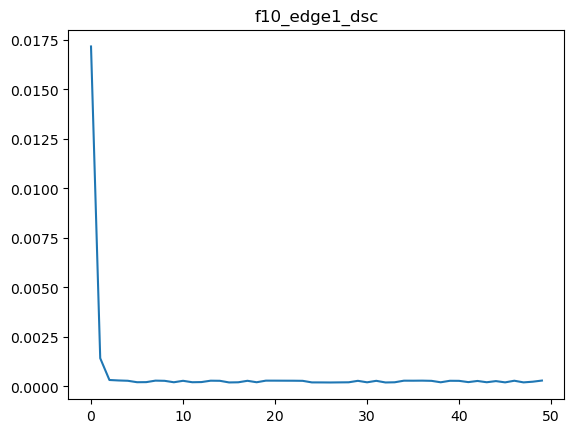

In [184]:
plt.plot(train_losses)
plt.title('f10_edge1_dsc')
plt.show()

In [181]:
torch.save(model.state_dict(), 'f10_edge1_dsc')

In [175]:
model.eval()
data = state_uncontrolled.to(device)
pred_traj = torch.zeros(500,2,10)
pred_traj[0,:,:] = state_uncontrolled[0,:,:]
nocontrol_test = torch.zeros(n_nodes).unsqueeze(0).to(device) 
for i in range(500-1):
    x = torch.cat((pred_traj[i,:,:], nocontrol_test), dim=0)
    pred = model(x.T,edge_index,edge_attr)[0]
    pred_traj[i+1,:,:] = pred.T

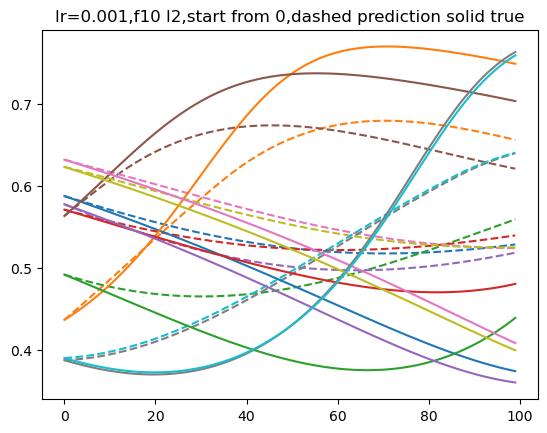

In [178]:
plt.plot(pred_traj[:100,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:100,0,:],label='true')
plt.title('lr=0.001,f10 l2,start from 0,dashed prediction solid true')
plt.show()

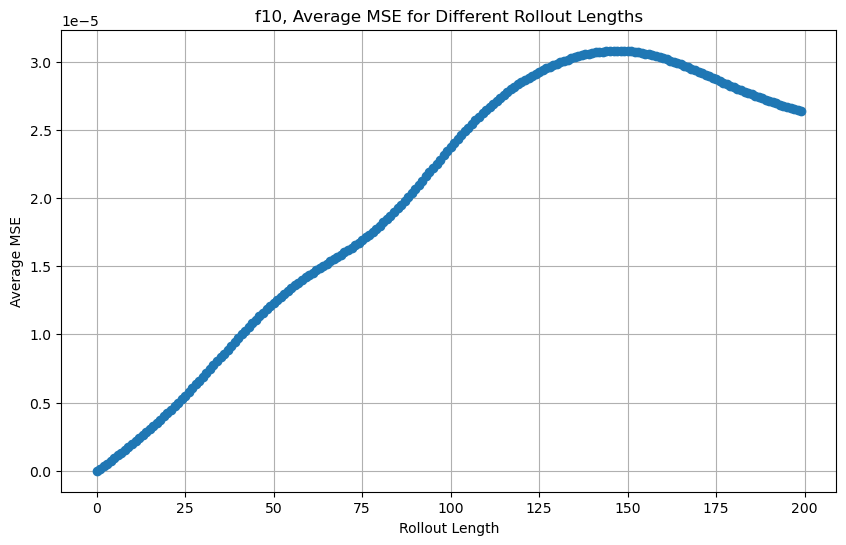

In [179]:
# Calculate MSE for each rollout length
ave_mse_values = []
loss_fn = nn.MSELoss()
for i in range(200):
    mse = loss_fn(data[:i+1,:,:], pred_traj[:i+1,:,:].detach())
    ave_mse = mse / (i+1)
    ave_mse_values.append(ave_mse)

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(ave_mse_values, marker='o')
plt.title('f10, Average MSE for Different Rollout Lengths')
plt.xlabel('Rollout Length')
plt.ylabel('Average MSE')
plt.grid(True)
plt.show()

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
data = state_uncontrolled.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()
look_ahead = 10

train_losses = []  
val_losses = []
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
                                         
    for t in range(1,traj_states.shape[0]-look_ahead+1):
        
        optimizer.zero_grad()
        #make 1 step prediction for the next k steps
        loss = 0
        current_state = torch.cat((traj_states[t-1,:],traj_controls[t-1,:]),dim=0)
        for k in range(look_ahead):
            #print(current_state.shape)
            prediction = model(current_state.T,edge_index,edge_attr)[0].T
            loss = loss + loss_fn(prediction, traj_states[t+k,:])
            #print(prediction.shape,traj_controls[t+k,:].shape)
            current_state = torch.cat((prediction,traj_controls[t+k,:]),dim=0)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_train_loss = total_loss / traj_states.shape[0]
    train_losses.append(avg_train_loss) 
    if (epoch + 1) % 10 == 0: 
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / traj_states.shape[0]}")

    # Validation (optional but recommended)
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for t in range(1,traj_states.shape[0]-look_ahead+1):
            current_state = torch.cat((traj_states[t-1,:],traj_controls[t-1,:]),dim=0)
            for k in range(look_ahead):
                prediction = model(current_state.T,edge_index,edge_attr)[0].T
                loss = loss + loss_fn(prediction, traj_states[t+k,:])  
                current_state = torch.cat((prediction,traj_controls[t+k,:]),dim=0)
            
            val_loss += loss.item()
        avg_val_loss = val_loss / traj_states.shape[0]
        val_losses.append(avg_val_loss)
        if (epoch + 1) % 10 == 0: 
            print(f"Validation Loss: {val_loss / traj_states.shape[0]}")

Epoch 10/50, Loss: 0.00028902000428172414
Validation Loss: 5.565245780363199
Epoch 20/50, Loss: 0.00023231666014070622
Validation Loss: 3.84168854784771
Epoch 30/50, Loss: 0.00020347425291885202
Validation Loss: 5.597936288991021
Epoch 40/50, Loss: 0.0002508490402278009
Validation Loss: 5.371962940070301
Epoch 50/50, Loss: 0.0002222844262809455
Validation Loss: 5.488203415015557


In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
data = state_uncontrolled.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()
look_ahead = 50

train_losses = []  
val_losses = []
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
                                         
    for t in range(1,traj_states.shape[0]-look_ahead+1):
        
        optimizer.zero_grad()
        #make 1 step prediction for the next k steps
        loss = 0
        current_state = torch.cat((traj_states[t-1,:],traj_controls[t-1,:]),dim=0)
        for k in range(look_ahead):
            #print(current_state.shape)
            prediction = model(current_state.T,edge_index,edge_attr)[0].T
            loss = loss + loss_fn(prediction, traj_states[t+k,:])
            #print(prediction.shape,traj_controls[t+k,:].shape)
            current_state = torch.cat((prediction,traj_controls[t+k,:]),dim=0)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_train_loss = total_loss / traj_states.shape[0]
    train_losses.append(avg_train_loss) 
    if (epoch + 1) % 5 == 0: 
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / traj_states.shape[0]}")

Epoch 5/50, Loss: 0.10573050288564992
Epoch 10/50, Loss: 0.014709156919995924
Epoch 15/50, Loss: 0.012125038619536403
Epoch 20/50, Loss: 0.010811839122913322
Epoch 25/50, Loss: 0.00963476458095162
Epoch 30/50, Loss: 0.007952112781153726
Epoch 35/50, Loss: 0.006561957428576837
Epoch 40/50, Loss: 0.006913015106971822
Epoch 45/50, Loss: 0.00607598559819841
Epoch 50/50, Loss: 0.006937390464435642


In [64]:
torch.save(model.state_dict(), 'f50_l3_control')

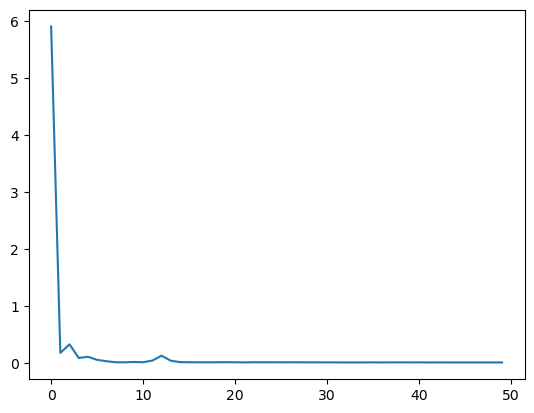

In [65]:
plt.plot(train_losses)
plt.show()

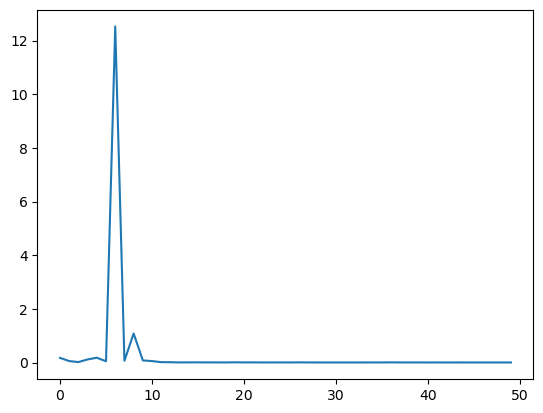

In [47]:
plt.plot(train_losses)
plt.show()

In [54]:
train_losses

[0.17603444258689221,
 0.05690086455764443,
 0.019440350620056657,
 0.11802159933546985,
 0.18133882390583556,
 0.049153610669513,
 12.528131991368369,
 0.06941620226251932,
 1.0844606563975103,
 0.0810057751062365,
 0.0561560902884036,
 0.016772720874016767,
 0.013935724417492565,
 0.006037019809417567,
 0.008310074166351721,
 0.008772599117022158,
 0.007281585745125388,
 0.007445150773903151,
 0.005399548383298679,
 0.010814014645986997,
 0.006189179655011685,
 0.008474316694414787,
 0.00531623619518723,
 0.005507889219128629,
 0.006844665182283886,
 0.0052322024031236656,
 0.009177218785671964,
 0.005474605408719071,
 0.005193751124206756,
 0.004977385688246917,
 0.005130151686077321,
 0.005090964492519561,
 0.004784601178164849,
 0.005175973288603928,
 0.0054123053418570636,
 0.0058518159062865985,
 0.009072221451082442,
 0.005512028199877629,
 0.005582842145413451,
 0.005550507812079256,
 0.004567603912793857,
 0.005396398954192894,
 0.004400160003853065,
 0.0051546373425371715,
 

In [56]:
train_losses

[0.439999847085448,
 48905.60956004191,
 0.34754941113929577,
 0.2709726863221343,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [72]:
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
model.load_state_dict(torch.load('f10_l2_control'))

<All keys matched successfully>

In [73]:
model.eval()
data = state_uncontrolled.to(device)
pred_traj = torch.zeros(500,2,10)
pred_traj[0,:,:] = state_uncontrolled[0,:,:]
nocontrol_test = torch.zeros(n_nodes).unsqueeze(0).to(device) 
for i in range(500-1):
    x = torch.cat((pred_traj[i,:,:], nocontrol_test), dim=0)
    pred = model(x.T,edge_index,edge_attr)[0]
    pred_traj[i+1,:,:] = pred.T

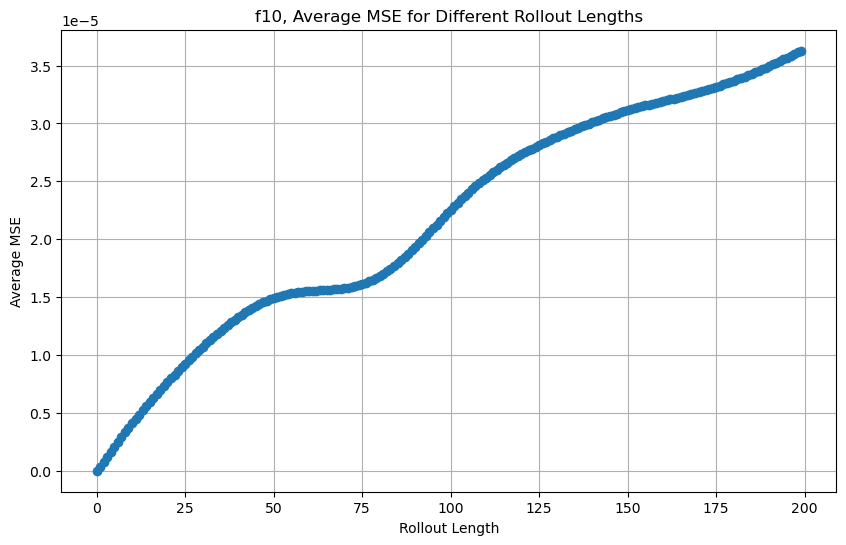

In [76]:
# Calculate MSE for each rollout length
ave_mse_values = []
loss_fn = nn.MSELoss()
for i in range(200):
    mse = loss_fn(data[:i+1,:,:], pred_traj[:i+1,:,:].detach())
    ave_mse = mse / (i+1)
    ave_mse_values.append(ave_mse)

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(ave_mse_values, marker='o')
plt.title('f10, Average MSE for Different Rollout Lengths')
plt.xlabel('Rollout Length')
plt.ylabel('Average MSE')
plt.grid(True)
plt.show()

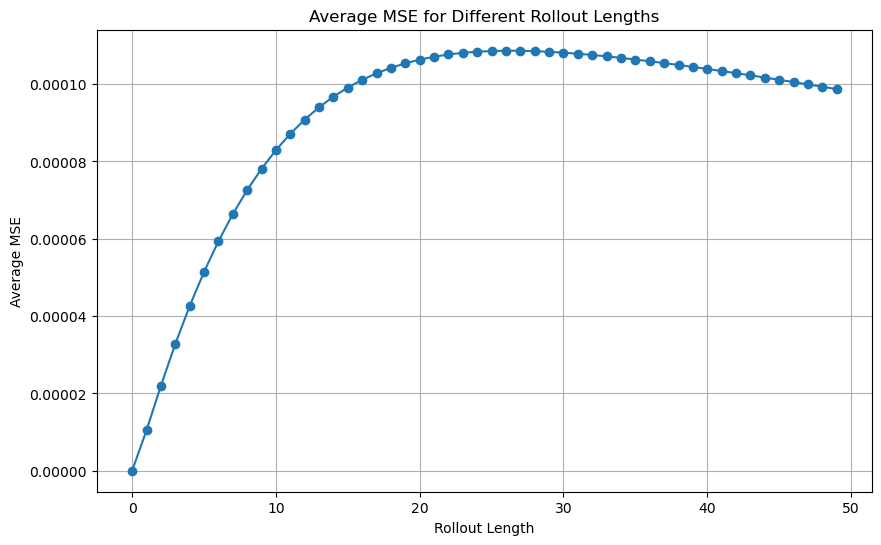

In [68]:
# Calculate MSE for each rollout length
ave_mse_values = []
loss_fn = nn.MSELoss()
for i in range(50):
    mse = loss_fn(data[:i+1,:,:], pred_traj[:i+1,:,:].detach())
    ave_mse = mse / (i+1)
    ave_mse_values.append(ave_mse)

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(ave_mse_values, marker='o')
plt.title('Average MSE for Different Rollout Lengths')
plt.xlabel('Rollout Length')
plt.ylabel('Average MSE')
plt.grid(True)
plt.show()

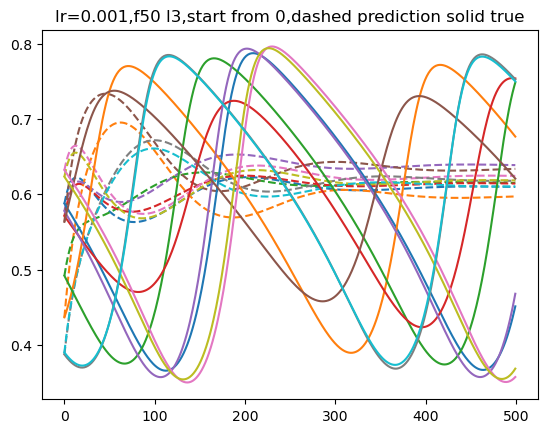

In [69]:
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:500,0,:],label='true')
plt.title('lr=0.001,f50 l3,start from 0,dashed prediction solid true')
plt.show()

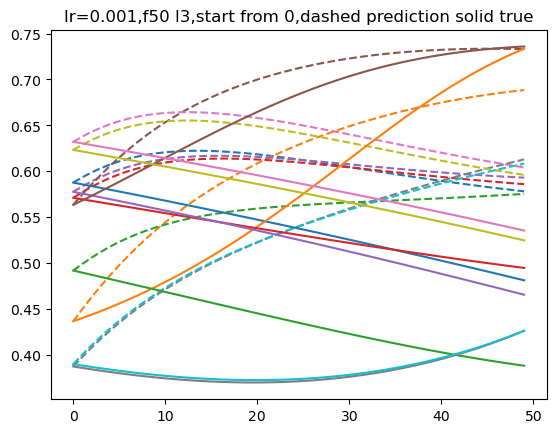

In [70]:
plt.plot(pred_traj[:50,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:50,0,:],label='true')
plt.title('lr=0.001,f50 l3,start from 0,dashed prediction solid true')
plt.show()

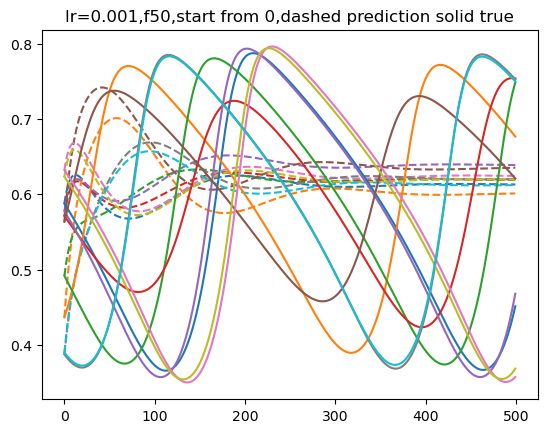

In [52]:
plt.plot(pred_traj[:500,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:500,0,:],label='true')
plt.title('lr=0.001,f50,start from 0,dashed prediction solid true')
plt.show()

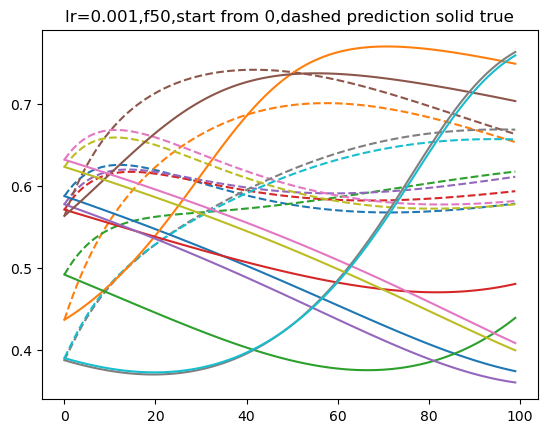

In [53]:
plt.plot(pred_traj[:100,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:100,0,:],label='true')
plt.title('lr=0.001,f50,start from 0,dashed prediction solid true')
plt.show()

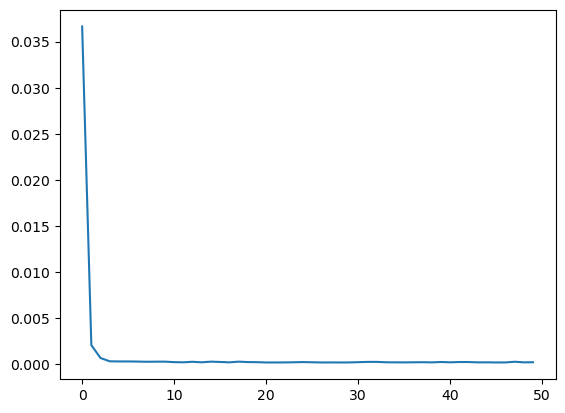

In [32]:
plt.plot(train_losses)
plt.show()

In [31]:
torch.save(model.state_dict(), 'f10_l2_control')

In [30]:
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
model.load_state_dict(torch.load('f10_l2_control'))

<All keys matched successfully>

In [31]:
model.eval()
data = state_uncontrolled.to(device)
pred_traj = torch.zeros(500,2,10)
pred_traj[0,:,:] = state_uncontrolled[0,:,:]
nocontrol_test = torch.zeros(n_nodes).unsqueeze(0).to(device) 
for i in range(500-1):
    x = torch.cat((pred_traj[i,:,:], nocontrol_test), dim=0)
    pred = model(x.T,edge_index,edge_attr)[0]
    pred_traj[i+1,:,:] = pred.T

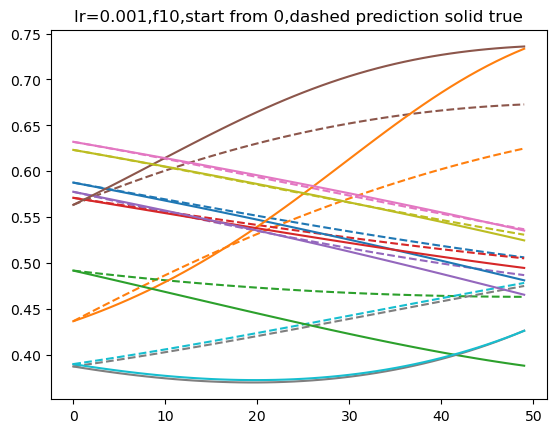

In [77]:
plt.plot(pred_traj[:50,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:50,0,:],label='true')
plt.title('lr=0.001,f10,start from 0,dashed prediction solid true')
plt.show()

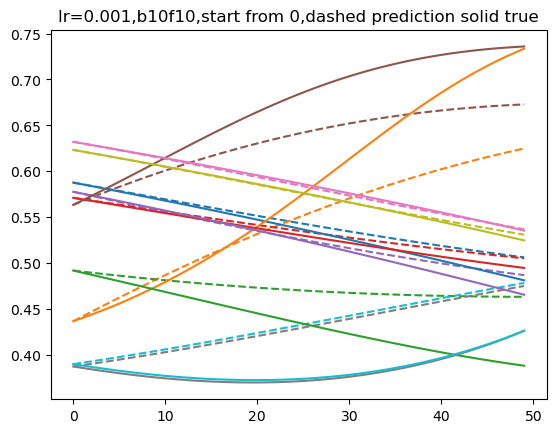

In [34]:
plt.plot(pred_traj[:50,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:50,0,:],label='true')
plt.title('lr=0.001,b10f10,start from 0,dashed prediction solid true')
plt.show()

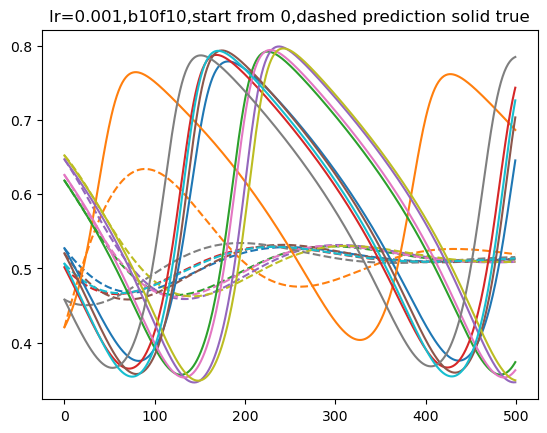

In [41]:
plt.plot(pred_traj[:,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:500,0,:],label='true')
plt.title('lr=0.001,b10f10,start from 0,dashed prediction solid true')
plt.show()

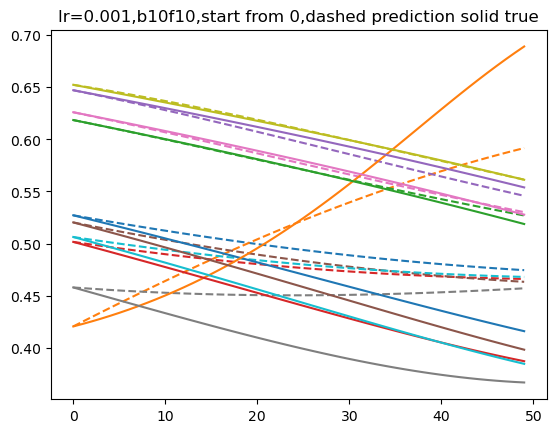

In [42]:
plt.plot(pred_traj[:50,0,:].detach(),'--',label='prediction')
plt.plot(state_uncontrolled[:50,0,:],label='true')
plt.title('lr=0.001,b10f10,start from 0,dashed prediction solid true')
plt.show()

In [38]:
def cross_correlation_matrix(x , tsteps , N):
    #if not isinstance(x, torch.Tensor):
        #x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    #elif not x.requires_grad:
        #x.requires_grad_(True)
    #x.retain_grad()
    means = (1/tsteps) * torch.sum(x, dim=0)
    stds = torch.sqrt(torch.sum((x - means)**2, dim=0))
    stdsgrid = torch.ones((N, 1)) * stds
    stdsgrid = stdsgrid.transpose(0, 1) * stdsgrid
    xcc = x - means
    cross_correlation_mat = torch.matmul(xcc.transpose(0, 1), xcc) / stdsgrid

    return cross_correlation_mat 

def f_sync_torch(control,tsteps , d , dt , N ,   I_p ,   I_e ,   I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise):
    adj = torch.ones(N,N)
    torch.diagonal(adj, 0).zero_()
    edge_index = adj.nonzero().t().contiguous()
    edge_attr = A[edge_index[0], edge_index[1]]
    
    control=control.reshape(tsteps,N)

    #if not isinstance(control, torch.Tensor):
        #control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    #elif not control.requires_grad:
        #control.requires_grad_(True)
    control.retain_grad()

    state = torch.zeros(tsteps,2,N)
    state[0,:,:] = node_ic
    for i in range(tsteps-1):
        x = torch.cat((state[i,:,:], control[i,:].unsqueeze(0)), dim=0)
        pred = model(x.T,edge_index,edge_attr)[0]
        state[i+1,:,:] = pred.T
    state = state[:,0,:]

    cc = cross_correlation_matrix(state , tsteps , N)
    f1 =   I_p * (1/4)* torch.sum((cc -   target_output)**2)
    f2=   I_e/2 * (control**2).sum() 
    if   I_s>1e-10:
        controlsum= torch.sum(control**2, dim=0)**(1.0 / 2.0)#
        f3 =   I_s  *torch.sum(controlsum)
    else:
        f3=0
    return (f1+f2+f3) 

def fprime_sync_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise):

    control=control.view(tsteps,N)

    control.retain_grad()
    # compute the function value
    y = f_sync_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,node_ic,realizations,noise)
    # backward() computes the gradient and accumulates it in x.grad
    #torch.autograd.set_detect_anomaly(True)
    y.backward(retain_graph=True)

    return  control.grad.view(tsteps*N)

In [84]:
# Closed-loop controller using shorter rollouts
# node_ic is k-steps long
def closed_loop_controller(rollout_length, functional, control, gradient, max_k=1000, **args):
    tsteps = args['tsteps'] #timesteps, int
    dt = args['dt'] #stepsize of timesteps, float
    N = args['N'] #number of nodes, int
    d = args['d'] #dimension of oscillator dynamnode_ics, int
    target_output = args['target_output'] #desired/target state, array shape(tsteps,N)
    node_ic= args['node_ic'] #initial conditions of the network dynamnode_ics, array shape(d,N),

    # Calculate the total number of rollouts
    num_rollouts = int(tsteps / rollout_length)
    # Set the time horizon for the current rollout
    args['tsteps'] = rollout_length

    current_state = node_ic
    total_control = []
    total_controlled_traj = []

    for rollout in range(1):
        iteration=0 
        
        # 3. Run the FR_algorithm for the current rollout
        result = FR_algorithm(functional, control, gradient, max_k=500, **args)
        iteration+=result[4]
        print('Rollout',rollout,'Code finished after ',iteration,' iterations with warnflag',result[2])
        control_rollout=result[0].detach().reshape(rollout_length,N)
        #print(control_rollout.grad)
        total_control.append(control_rollout)

        # 4. Propagate the system with the optimized control to get the new state

        pred_traj = torch.zeros(rollout_length,2,N)
        pred_traj[0,:,:] = node_ic
        #print(control_rollout.shape)
        control_expanded = control_rollout.unsqueeze(1)
        #print(control_expanded.shape)
        for i in range(rollout_length-1):
            x = torch.cat((pred_traj[i,:,:], control_expanded[i,:,:]), dim=0)
            pred = model(x.T,edge_index,edge_attr)[0]
            pred_traj[i+1,:,:] = pred.T
            
        total_controlled_traj.append(pred_traj)
        args['node_ic'] = pred_traj[-1,:,:]

    return total_control, total_controlled_traj

In [85]:
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
model.load_state_dict(torch.load('f50_l3_control'))

for param in model.parameters():
    param.requires_grad = False
functional=f_sync_torch
gradient=fprime_sync_torch

rollout_length = 500
control = torch.ones(rollout_length*n_nodes, requires_grad=True)
control.data *= -0.002
iteration = 0
args['node_ic']=state_uncontrolled[0,:,:]
total_control_3, total_controlled_traj_3 = closed_loop_controller(rollout_length, functional, control, gradient, max_k=1000, **args)

gnorm tensor(8.6412e-05) uknorm tensor(8.4502e-05, grad_fn=<MaxBackward1>)
Rollout 0 Code finished after  29  iterations with warnflag 0


In [80]:
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
model.load_state_dict(torch.load('f50_l3_control'))

for param in model.parameters():
    param.requires_grad = False
functional=f_sync_torch
gradient=fprime_sync_torch

rollout_length = 100
control = torch.ones(rollout_length*n_nodes, requires_grad=True)
control.data *= -0.002
iteration = 0
args['node_ic']=state_uncontrolled[0,:,:]
total_control_2, total_controlled_traj_2 = closed_loop_controller(rollout_length, functional, control, gradient, max_k=1000, **args)

gnorm tensor(9.8495e-05) uknorm tensor(3.8141e-05, grad_fn=<MaxBackward1>)
Rollout 0 Code finished after  22  iterations with warnflag 0
Maximal iteration of FR algorithm reached.
Rollout 1 Code finished after  500  iterations with warnflag 1
gnorm tensor(9.5411e-05) uknorm tensor(0.0002, grad_fn=<MaxBackward1>)
Rollout 2 Code finished after  13  iterations with warnflag 0
Maximal iteration of FR algorithm reached.
Rollout 3 Code finished after  500  iterations with warnflag 1
gnorm tensor(2.6482e-05) uknorm tensor(5.5556e-05, grad_fn=<MaxBackward1>)
Rollout 4 Code finished after  27  iterations with warnflag 0
gnorm tensor(6.7018e-05) uknorm tensor(9.9898e-06, grad_fn=<MaxBackward1>)
Rollout 5 Code finished after  92  iterations with warnflag 0
gnorm tensor(9.5998e-05) uknorm tensor(6.3574e-05, grad_fn=<MaxBackward1>)
Rollout 6 Code finished after  15  iterations with warnflag 0
gnorm tensor(6.4719e-05) uknorm tensor(1.8976e-05, grad_fn=<MaxBackward1>)
Rollout 7 Code finished after  6

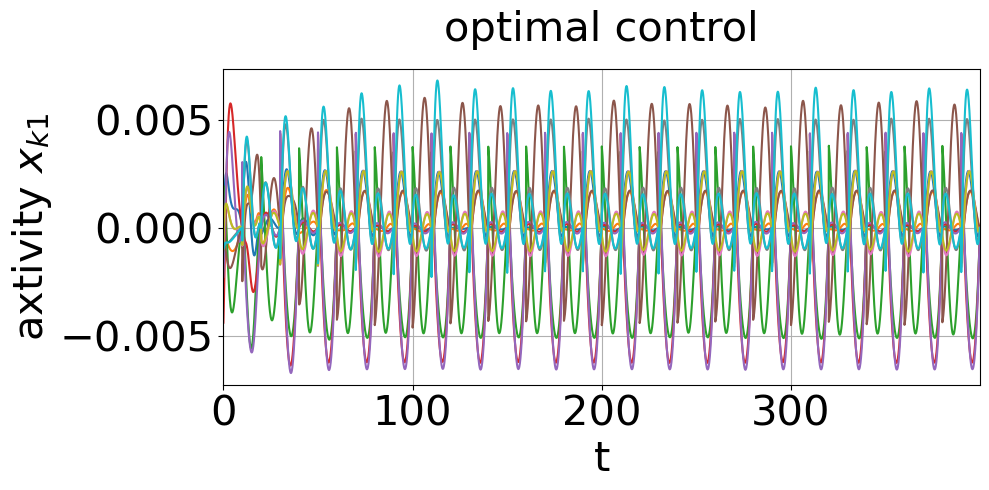

In [81]:
tensor_control_2 = torch.cat(total_control_2, dim=0)
create_plot(tensor_control_2,'axtivity $x_{k1}$','optimal control')
plt.show()

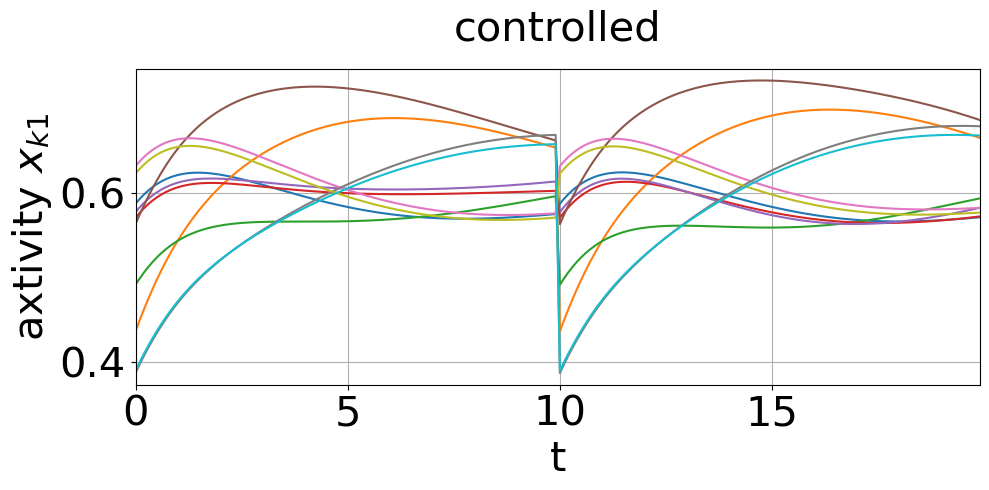

In [83]:
tensor_traj_2 = torch.cat(total_controlled_traj_2, dim=0)
create_plot(tensor_traj_2[:200,0,:].detach(),'axtivity $x_{k1}$','controlled')
plt.show()

In [40]:
for param in model.parameters():
    param.requires_grad = False
functional=f_sync_torch
gradient=fprime_sync_torch

rollout_length = 30
control = torch.ones(rollout_length*n_nodes, requires_grad=True)
control.data *= -0.002
iteration = 0
args['node_ic']=state_uncontrolled[0,:,:]
total_control, total_controlled_traj = closed_loop_controller(rollout_length, functional, control, gradient, max_k=1000, **args)

Maximal iteration of FR algorithm reached.
Rollout 0 Code finished after  500  iterations with warnflag 1
gnorm tensor(0.0066) uknorm tensor(0., grad_fn=<MaxBackward1>)
Rollout 1 Code finished after  88  iterations with warnflag 0
Maximal iteration of FR algorithm reached.
Rollout 2 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 3 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 4 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 5 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 6 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 7 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 8 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR alg

Maximal iteration of FR algorithm reached.
Rollout 77 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 78 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 79 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 80 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 81 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 82 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 83 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 84 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm reached.
Rollout 85 Code finished after  500  iterations with warnflag 1
Maximal iteration of FR algorithm rea

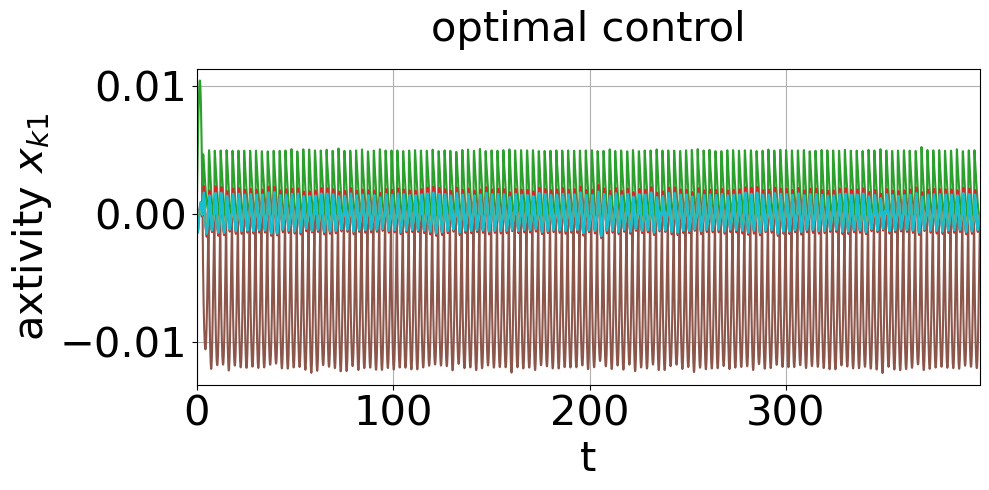

In [44]:
tensor_control = torch.cat(total_control, dim=0)
create_plot(tensor_control,'axtivity $x_{k1}$','optimal control')
plt.show()

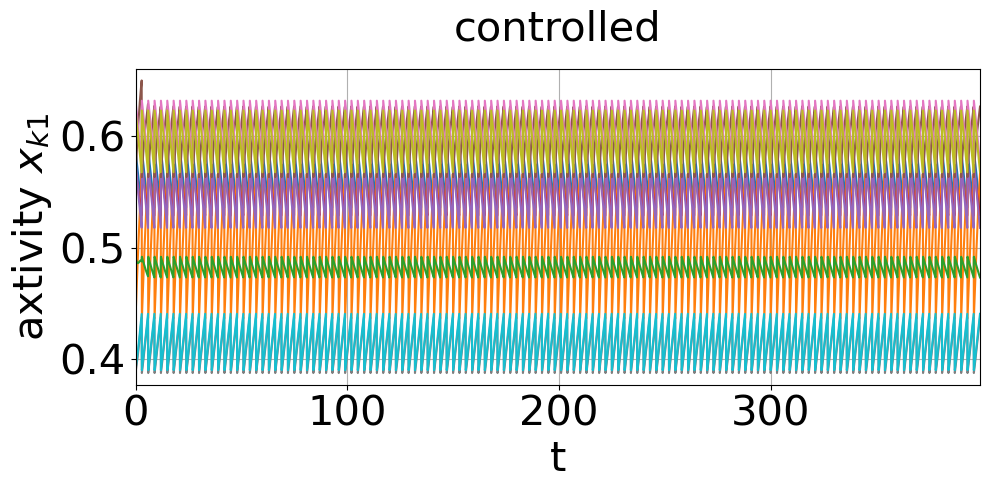

In [45]:
tensor_traj = torch.cat(total_controlled_traj, dim=0)
create_plot(tensor_traj[:,0,:].detach(),'axtivity $x_{k1}$','controlled')
plt.show()

In [ ]:
# Closed-loop controller using shorter rollouts
# node_ic is k-steps long
def closed_loop_controller(rollout_length, functional, control, gradient, max_k=1000, **args):
    tsteps = args['tsteps'] #timesteps, int
    dt = args['dt'] #stepsize of timesteps, float
    N = args['N'] #number of nodes, int
    d = args['d'] #dimension of oscillator dynamnode_ics, int
    target_output = args['target_output'] #desired/target state, array shape(tsteps,N)
    node_ic= args['node_ic'] #initial conditions of the network dynamnode_ics, array shape(d,N),

    # Calculate the total number of rollouts
    num_rollouts = int(tsteps / rollout_length)
    # Set the time horizon for the current rollout
    args['tsteps'] = rollout_length

    current_state = node_ic
    total_control = []
    total_controlled_traj = []

    for rollout in range(1):
        iteration=0 
        
        # 3. Run the FR_algorithm for the current rollout
        result = FR_algorithm(functional, control, gradient, max_k=500, **args)
        iteration+=result[4]
        print('Rollout',rollout,'Code finished after ',iteration,' iterations with warnflag',result[2])
        control_rollout=result[0].detach().reshape(rollout_length,N)
        #print(control_rollout.grad)
        total_control.append(control_rollout)

        # 4. Propagate the system with the optimized control to get the new state

        pred_traj = torch.zeros(rollout_length,2,N)
        pred_traj[0,:,:] = node_ic
        #print(control_rollout.shape)
        control_expanded = control_rollout.unsqueeze(1)
        #print(control_expanded.shape)
        for i in range(rollout_length-1):
            x = torch.cat((pred_traj[i,:,:], control_expanded[i,:,:]), dim=0)
            pred = model(x.T,edge_index,edge_attr)[0]
            pred_traj[i+1,:,:] = pred.T
            
        total_controlled_traj.append(pred_traj)
        args['node_ic'] = pred_traj[-1,:,:]
    
        # This can be a simulation of your system using the optimized control for the current rollout. 
        # Depending on your problem, you might already have such a function or you might need to write one.

    return total_control, total_controlled_traj

In [104]:
def cross_correlation_matrix(x , horizen_length , N):
    #if not isinstance(x, torch.Tensor):
        #x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    #elif not x.requires_grad:
        #x.requires_grad_(True)
    #x.retain_grad()
    means = (1/tsteps) * torch.sum(x, dim=0)
    stds = torch.sqrt(torch.sum((x - means)**2, dim=0))
    stdsgrid = torch.ones((N, 1)) * stds
    stdsgrid = stdsgrid.transpose(0, 1) * stdsgrid
    xcc = x - means
    cross_correlation_mat = torch.matmul(xcc.transpose(0, 1), xcc) / stdsgrid

    return cross_correlation_mat 

def sync_loss(state,horizen_length,N,I_p, I_e, I_s,target_output):


    #if not isinstance(control, torch.Tensor):
        #control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    #elif not control.requires_grad:
        #control.requires_grad_(True)
    control.retain_grad()

    state = state[:,0,:]

    cc = cross_correlation_matrix(state , horizen_length , N)
    f1 =   I_p * (1/4)* torch.sum((cc -   target_output)**2)
    f2=   I_e/2 * (control**2).sum() 
    if   I_s>1e-10:
        controlsum= torch.sum(control**2, dim=0)**(1.0 / 2.0)#
        f3 =   I_s  *torch.sum(controlsum)
    else:
        f3=0
    return (f1+f2+f3) 

In [125]:
def MPC_RHC(model, edge_index, edge_attr,sim_t, horizon_length=50, **args):
    N = args['N']
    I_p = args['I_p']
    I_e = args['I_e']
    I_s = args['I_s']
    target_output = args['target_output']
    node_ic = args['node_ic']

    current_state = node_ic
    total_control = []
    total_controlled_traj = []

    # Define the optimizer
    # Initialize control input as a learnable parameter for the given horizon
    control_input = torch.ones((horizon_length,N), requires_grad=True)
    control_input.data *= -0.002
    #control_input = torch.nn.Parameter(torch.randn(horizon_length, N))
    optimizer = torch.optim.Adam([control_input], lr=0.001)

    for t in range(sim_t):
        # Reset the optimizer's gradients
        optimizer.zero_grad()

        # Optimize over the given horizon
        pred_traj = torch.zeros(horizon_length, 2, N)
        #print(current_state.shape,current_state.T.shape)
        pred_traj[0, :, :] = current_state
        control_expanded = control_input.unsqueeze(1)
        
        for h in range(horizon_length - 1):
            x = torch.cat((pred_traj[h, :, :], control_expanded[h, :, :]), dim=0)
            pred = model(x.T, edge_index, edge_attr)[0]
            pred_traj[h + 1, :, :] = pred.T

        # Define the loss function (Mean Squared Error Loss in this case)
        loss = sync_loss(pred_traj,horizon_length,N,I_p, I_e, I_s,target_output)
        loss.backward()
        optimizer.step()
        
        # Use the first optimized control input
        applied_control = control_input[0,:].detach()
        total_control.append(applied_control)

        # Propagate the system with the applied control to get the new state
        x = torch.cat((current_state, applied_control.unsqueeze(0)), dim=0)
        next_state = model(x.T, edge_index, edge_attr)[0].T
        
        total_controlled_traj.append(next_state)
        
        # Update the current state
        current_state = next_state
        if t % 100 == 0:         
            print(f'Timestep {t}, Loss: {loss.item()}')

    return total_control, total_controlled_traj

In [126]:
for param in model.parameters():
    param.requires_grad = False
total_control_5, total_controlled_traj_5 = MPC_RHC(model, edge_index, edge_attr,sim_t=1000, horizon_length=50, **args)

Timestep 0, Loss: 0.010000300593674183
Timestep 100, Loss: 0.010000006295740604
Timestep 200, Loss: 0.010000002570450306
Timestep 300, Loss: 0.010000001639127731
Timestep 400, Loss: 0.010000001639127731
Timestep 500, Loss: 0.010000001639127731
Timestep 600, Loss: 0.010000001639127731
Timestep 700, Loss: 0.010000001639127731
Timestep 800, Loss: 0.010000001639127731
Timestep 900, Loss: 0.010000001639127731


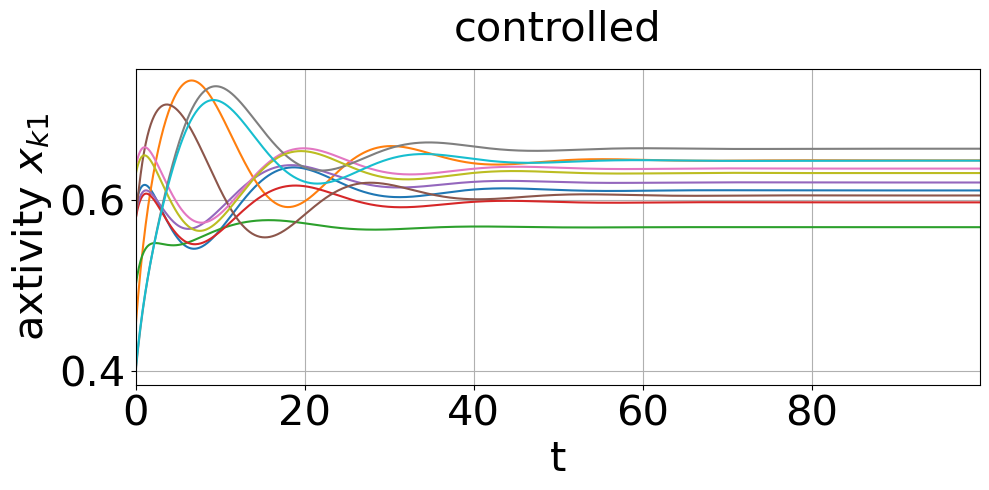

In [134]:
tensor_traj_5 = torch.stack(total_controlled_traj_5, dim=0)
create_plot(tensor_traj_5[:,0,:].detach(),'axtivity $x_{k1}$','controlled')
plt.show()

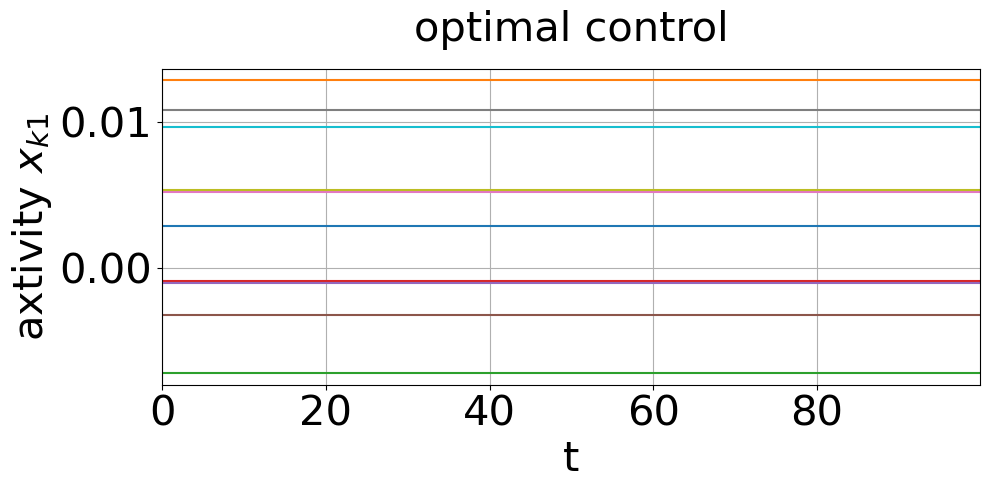

In [140]:
tensor_control_5 = torch.stack(total_control_5, dim=0)
create_plot(tensor_control_5,'axtivity $x_{k1}$','optimal control')
plt.show()

In [36]:
def vecnorm(x, ord=2):
    '''Returns the norm of x'''
    if ord == float('inf'):
        return torch.max(torch.abs(x))
    elif ord == float('-inf'):
        return torch.min(torch.abs(x))
    else:
        return torch.sum(torch.abs(x)**ord, dim=0)**(1.0 / ord)

def bisection(f, uk , fprime, fk , gk , pk  ,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,target_output,node_ic , realizations,noise  ,max_iter=10000 , max_alpha = 5000 , c1=1e-10 ):
    """
    Find stepsize with simple bisection.

    Parameters
    ----------
        f : function
            cost functional to be minimized
        uk : array shape (tsteps*N,)
            control
        fprime : function
            function returning the gradient of the cost functional
        fk : float
            vaue of the cost functional
        gk : array shape (tsteps*N,)
            gradient of the cost functional fk
        pk : array shape (tsteps*N,)
            descent direction (from polak ribiere method)
        tsteps : int
            number of timesteps
        d : int
            dimension of local dynamics (e.g. for FHN-oscillator d=2)
        dt : float
            stepsize of integration
        N : int
            number of nodes
        I_p : array of shape (tsteps,N) 
            weight of precision term of cost functional
        I_e : float
            weight of energy term of cost functional
        I_s : float
            weight of sparsity term of cost functional
        alpha , beta, gamma, delta, epsilon, tau, mu ,sigma : floats
            parameters of the FHN-oscillator
        A : array shape (N,N)
            adjacency matrix  
        target_output : array of shape (tsteps,N) 
            the oscillator's activity of the desired state (only the 1st dimension of the FHN oscillators is considered)
        node_ic : array shape (d,N)
            initial conditions of the controlled state

    Returns
    -------
    ukp : array shape (tsteps*N,)
        new control
    fkp : float
        new cost functional
    gkp : array shape (tsteps*N,)
        new gradient of cost functional
    gval_alpha[0] : float
        stepsize
    """

    #1. initialize
    gval = [None]
    gval_alpha = [None]
    minimal_alphastep=1e-17
    
    #2. test to see whether direction pk from Polak Ribiere method is actually a descet direction. If not use -gk, the negative gradient of the cost functional, instead.
    fkp_test = f(uk + 1e-13 * pk, tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,target_output,node_ic,realizations,noise)
    if fkp_test>fk or torch.isnan(fkp_test):
     #   print('Replaced PR descent direction with negative gradient at x0[10]',uk[10])
        pk = -gk

    #3. function calculating the cost functional for the control uk + alpha2*pk.
    def phi(alpha2):
        return f(uk + alpha2*pk, tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A, target_output,node_ic,realizations,noise)
    
    def loop_for_stepsize(pk,alpha_ini):
    #4. initialize
        warning=3
        alpha1=alpha_ini #start with a large stepsize
        iteration=0
    
        #5. loop for finding the stepsize
        while warning==3:
            alpha1=alpha1/2
           # print(alpha1)
            if iteration > max_iter or alpha1 < minimal_alphastep:
                print('Bisection: minimal alphastep or max iteration reached:',alpha1)
                ukp=uk.clone()
                break
    
            if torch.max(torch.abs(uk + alpha1 * pk))<50: #set this condition, since for larger control values the network dynamics might diverge
                fkp = phi(alpha1)
               # print(alpha1,fk,fkp)
                if (fkp <= fk ): #
                    warning=0    
                #    print('found!')
                    ukp = uk + alpha1*pk 
                    break

            iteration += 1
        return warning , ukp , fkp , alpha1 

    alpha_ini=100
    warning , ukp , fkp , alpha1  = loop_for_stepsize(pk,alpha_ini)
    #print(pk)
    if not isinstance(ukp, torch.Tensor):
        ukp = torch.tensor(ukp, dtype=torch.float32, requires_grad=True)
    elif not ukp.requires_grad:
        ukp.requires_grad_(True)


    #6.   
    if warning==3:
    #no stepsize found  . functional might be too flat
    #retry with different stepsizes
        alpha_ini=15
        warning , ukp , fkp , alpha1  = loop_for_stepsize(pk,alpha_ini)  

    if warning==3:
        gval_alpha[0]=None
        ukp=uk.clone()
        fkp=fk
        gkp=gk.clone()

    else:
    #stepsize found.
        gval_alpha[0]=alpha1
        ukp.retain_grad()
        gkp=fprime(ukp, tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A, target_output,node_ic,realizations,noise   ) 
    return ukp , fkp , gkp , gval_alpha[0] 

def direction(k , gk, gkp , pk):
    """
    Calculate the descent direction with Polak-Ribiere method. Every hundredth iteration set to zero/reset.

    Parameters
    ----------
    k : int
        iteration
    gk : array shape (tsteps*N,)
        old gradient of the cost functional (from previous iteration step)
    gkp : array shape (tsteps*N,)
        new gradient of the cost functional
    pk : array shape (tsteps*N,)
        old descent direction (from previous iteration step)

    Returns
    -------
    pkp:array shape (tsteps*N,)
        new descent direction
    """
    if k%100==0:
        betak=0
    else:
        gkdiff=gkp-gk
        #Polak-Ribiere method:
        betak = torch.max(torch.tensor(0), torch.dot(gkp, (gkdiff)) / torch.dot(gk, gk) )
        #print(betak)
        #Hestenes-Stiefel method:
      #  betak= max(0, np.dot(gkp, gkdiff) / np.dot(pk, gkdiff) )
    pkp = -gkp + betak*pk
    return pkp

def FR_algorithm(f,x0,fprime,max_k=250,gtol=1e-4,**args):
    """
    Fletcher and reeves algorithm, conjugate gradient method to calvulate optimal solution of control.

    Parameters
    ----------
    f : function
        cost functional to be minimized
    x0 : array shape (tsteps*N,)
        initial values of control
    fprime : function
        function returning the gradient of the cost functional
    max_k : int
        maximal iteration number, set to 500 if no value is given
    gtol : float
        critnode_ical value, when the gradient is smaller than gtol*(1+functional) th control is optimal
    args :  dnode_ictionary
        all arguments needed for the calculation of f and fprime

    Returns
    -------
    uk : array shape (tsteps*N)
        resulting control
    fk : float
        resulting cost functional
    warnflag : int can be 0,1 or 3
        status warflag=0--> solved, uk is the optimal control.
               warnflag=1-> further iterations are needed.
               warflag=3--> error. the derivative does not match the cost functional
    k : int
        number of iterations
    gnorm : float
        Inf-norm of gradient at last iteration step
    pk : array shape (tsteps*N,)
        descent direction at last iteration step
    gk : array shape (tsteps*N,)
        gradient at last iteration step
   """
    #1. load args
    tsteps = args['tsteps'] #timesteps, int
    dt = args['dt'] #stepsize of timesteps, float
    N = args['N'] #number of nodes, int
    d = args['d'] #dimension of oscillator dynamnode_ics, int
    alpha = args['alpha'] #parameter of FHN oscillator, float
    beta = args['beta'] #parameter of FHN oscillator, float
    gamma = args['gamma'] #parameter of FHN oscillator, float
    delta = args['delta'] #parameter of FHN oscillator, float
    epsilon = args['epsilon'] #parameter of FHN oscillator, float
    tau = args['tau'] #parameter of FHN oscillator, float
    mu = args['mu'] #parameter of FHN oscillator, float
    sigma = args['sigma'] #parameter of FHN oscillator, float
    A = args['A'] #adjacency matrix, array shape(N,N)
    I_p = args['I_p'] #weight of the precision term of the cost functional, float
    I_e = args['I_e'] #weight of the energy term of the cost functional, float
    I_s = args['I_s'] #weight of the sparsity term of the cost functional, float
    target_output = args['target_output'] #desired/target state, array shape(tsteps,N)
    node_ic= args['node_ic'] #initial conditions of the network dynamnode_ics, array shape(d,N),
    realizations=args['realizations']
    noise=args['noise']
    gk_list = []
    fk_list = []


    #2. Iitialization
    uk=x0
    fk=f(uk,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,target_output,node_ic,realizations,noise)
    gk=fprime(uk, tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,target_output,node_ic ,realizations,noise)
    gk_list.append(gk.clone().detach())
    fk_list.append(fk.clone().detach())
    pk=-gk.clone()
    warnflag=0
    k=1
    gnorm=vecnorm(gk,float('inf'))


    not_ready=True

    #3f. terminate if the solution is already optimal.
    if gnorm<=gtol*(1+fk):
        not_ready=False

    #3. Loop to find optimal solution. Wranflag=0: optimal solution is found, break. Warnflag=1: solution is not optimal yet. Warnflag=3: Negative derivative was o descent direction, Error, break. 
    while not_ready:
        #if k%1==0:
        #    print('iteration',k)
        #3a. When maximal iteration step number max_k is reached break, in order to save values and restart.
        if k>=max_k:
            warnflag=1
            print('Maximal iteration of FR algorithm reached.')
            break


        #3b. use bisection to calculate the stepsize alphak and the resulting new control ukp, the new cost functional fkp, its gradient gkp.
        ukp , fkp , gkp , alphak  = bisection(f , uk , fprime , fk , gk , pk , tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A, target_output,node_ic,realizations,noise)
        #print(ukp , fkp , gkp)

        #3c. if alphak=None no stepsize was found for which f(uk)>f(uk+alphak*gk) holds. Something went wrong, the negative derivative was no descent direction. Error.
        if alphak==None:
            warnflag=3
            print('Problem with the linesearch.')
            break

        #3d. calculate the new descent direction.
        pkp = direction(k , gk, gkp , pk)

        #needed for 3f.
        gnorm=vecnorm(gkp,float('inf'))
        uknorm=vecnorm(uk-ukp,float('inf'))
        #print(gnorm,fkp)

        #3e. redifine
        uk=ukp.clone()
        fk=fkp#.clone()
        gk=gkp.clone()
        gk_list.append(gk.detach())
        fk_list.append(fk.detach())
        pk=pkp.clone()


        k+=1

        #3f. terminate the algorithm if the gradient becomes zero or the control does not change any more (because of box constrains on control).
        if gnorm<=gtol*(1+fkp) or uknorm<=1e-20:
            print("gnorm",gnorm,"uknorm",uknorm)
            break


    #4. return 
    return uk,fk,warnflag,gnorm,k,fk_list,gk_list



In [ ]:
state_control.shape

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
data = state_uncontrolled.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()

train_losses = []  
val_losses = []
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
                                         
    for i in range(traj_states.shape[0] - 1):
        state, control, next_state = trajectory[i,:,:], c[i,:], trajectory[i+1,:,:]
        
        states, controls, next_states = states.to(device).squeeze(0), controls.to(device), next_states.to(device).squeeze(0)
        state_control = torch.cat((states, controls), dim=0) #concatenate state and control
        
        optimizer.zero_grad()
        #make 1 step prediction for the next k steps
        loss = 0
        prediction = state_control[t-1,:]
        for k in range(look_ahead):
            prediction = model(prediction.T,edge_index,edge_attr)
            loss = loss + loss_fn(prediction[0], state_control[t+k,:])                                    
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss) 
    if (epoch + 1) % 10 == 0: 
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

    # Validation (optional but recommended)
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for states, controls, next_states in val_loader:
            states, controls, next_states = states.to(device).squeeze(0), controls.to(device), next_states.to(device).squeeze(0)
            state_control = torch.cat((states, controls), dim=0) #concatenate state and control
        
            optimizer.zero_grad()
            #make 1 step prediction for the next k steps
            loss = 0
            prediction = state_control[t-1,:]
            for k in range(look_ahead):
                prediction = model(prediction.T,edge_index,edge_attr)
                loss = loss + loss_fn(prediction[0], state_control[t+k,:]) 
            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if (epoch + 1) % 10 == 0: 
            print(f"Validation Loss: {val_loss / len(val_loader)}")